In [2]:
%run imports.ipynb

In [8]:
from dask_kubernetes import KubeCluster
cluster = KubeCluster(n_workers=30)
cluster

In [9]:
from dask.distributed import Client
client = Client(cluster)
client

Client Scheduler: tcp://10.34.230.231:44131 Dashboard: /user/carlo%20mariade%20marco1/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [3]:
allel.GenotypeDaskArray(callset_phase2['3L']['calldata/GT'])

<GenotypeDaskArray shape=(10640388, 1142, 2) dtype=int8>

In [11]:
allel.GenotypeDaskArray(callset_biallel['3L']['calldata/GT'])

<GenotypeDaskArray shape=(7897666, 1142, 2) dtype=int8>

-------------------------

In [4]:
call = callset_phase2
samples = list(call['3L/samples'])
contigs = ['3L', '3R', '2R', '2L', 'X']
samples = [str(s) for s in call["3L"]["samples"][:]]
tbl_samples = etl.fromcsv('samples.meta.txt', delimiter='\t')

In [5]:
hka_coluzzii = pd.read_csv('data/coluzzii_hka_summary.tab_beta.tab', delimiter='\t')
hka_coluzzii

,chrom,gene,segreg_c,pri_der_fix_c,score_c
0,3L,AGAP010313,112,5,9.697724
1,3L,AGAP010788,1306,2,0.483879
2,3L,AGAP010310,118,3,2.829025
3,3L,AGAP010742,1949,1,1.389827
4,3L,AGAP010780,258,1,0.176524
...,...,...,...,...,...
197,X,AGAP013093,28,1,0.673098
198,X,AGAP001028,43,4,15.590323
199,X,AGAP001031,16,3,20.297242
200,X,AGAP000940,435,5,1.747537


In [6]:
homogen_test = pd.read_csv('data/homogeneity_summary_beta.tab', sep = '\t')
homogen_test

,chrom,gene,score
0,3L,AGAP010313,0.452941
1,3L,AGAP010780,0.356441
2,3L,AGAP010781,0.617318
3,3L,AGAP010788,0.054937
4,3L,AGAP010317,0.280698
...,...,...,...
126,X,AGAP000998,0.945873
127,X,AGAP001050,0.041491
128,X,AGAP000940,0.176029
129,X,AGAP000934,0.009325


In [7]:
hka_hom_tbl = pd.merge(hka_coluzzii, homogen_test, on='gene', how='inner').rename(columns={"chrom_x": 'chrom', "score_c" : "hka_score", "score": "homogeneity_score"})
cols = [2,3,5]
hka_hom_tbl.drop(hka_hom_tbl.columns[cols],axis=1,inplace=True)
hka_hom_tbl.head()

,chrom,gene,hka_score,homogeneity_score
0,3L,AGAP010313,9.697724,0.452941
1,3L,AGAP010788,0.483879,0.054937
2,3L,AGAP010780,0.176524,0.356441
3,3L,AGAP010781,0.255798,0.617318
4,3L,AGAP010317,21.153299,0.280698


-------------------------------

In [8]:
tbl_genes  = (etl
    .fromgff3('data/Anopheles-gambiae-PEST_BASEFEATURES_AgamP4.2.sorted.gff3.gz')
    .unpackdict('attributes')
    .cut(2,3,4,9)
    .select(lambda rec: rec.type == 'gene')
    .rename('ID', 'gene')
    .todataframe()
)
tbl_genes.head()

,type,start,end,gene
0,gene,157348,186936,AGAP004677
1,gene,203779,205293,AGAP004678
2,gene,207894,210460,AGAP004679
3,gene,271285,271815,AGAP004680
4,gene,358329,359280,AGAP004681


In [9]:
tbl_pos = pd.merge(hka_hom_tbl, tbl_genes, on='gene', how='inner').drop(columns='type')
tbl_pos.head()

,chrom,gene,hka_score,homogeneity_score,start,end
0,3L,AGAP010313,9.697724,0.452941,293919,305802
1,3L,AGAP010788,0.483879,0.054937,10359660,10389853
2,3L,AGAP010780,0.176524,0.356441,10264908,10275038
3,3L,AGAP010781,0.255798,0.617318,10277400,10283541
4,3L,AGAP010317,21.153299,0.280698,413217,415064


In [10]:
m = tbl_samples.select(lambda r: r.m_s == 'M' and r.population == 'BFcol').values('ox_code').list()
s = tbl_samples.select(lambda r: r.m_s == 'S' and r.population == 'BFgam').values('ox_code').list()
index_m = [samples.index(i) for i in m]
index_s = [samples.index(i) for i in s]

In [11]:
ga = {chrom: allel.GenotypeDaskArray(call[chrom]['calldata/GT']) for chrom in contigs}

In [12]:
gm = {chrom: ga[chrom].take(index_m, axis=1) for chrom in contigs}

In [13]:
gs = {chrom: ga[chrom].take(index_s, axis=1) for chrom in contigs}

In [14]:
pos = {chrom: call[chrom]['variants/POS'][:] for chrom in contigs}

In [15]:
sort_pos = {chrom: allel.SortedIndex(pos[chrom]) for chrom in contigs}

In [16]:
ac_m = {chrom: gm[chrom].count_alleles() for chrom in contigs}
ac_s = {chrom: gs[chrom].count_alleles() for chrom in contigs}

---------------------------------

In [17]:
tbl_len = (tbl_pos.drop(['gene','hka_score','homogeneity_score'], axis=1)).values
tbl_len

array([['3L', 293919, 305802],
       ['3L', 10359660, 10389853],
       ['3L', 10264908, 10275038],
       ['3L', 10277400, 10283541],
       ['3L', 413217, 415064],
       ['3R', 52237449, 52248062],
       ['3R', 24056, 39486],
       ['3R', 149476, 153955],
       ['3R', 52457332, 52554377],
       ['3R', 461780, 478211],
       ['3R', 13603, 21758],
       ['3R', 466370, 468350],
       ['3R', 52614350, 52617318],
       ['3R', 52354660, 52358904],
       ['3R', 52418651, 52422892],
       ['3R', 49458955, 49484075],
       ['3R', 49983895, 50074391],
       ['3R', 52067738, 52115209],
       ['3R', 43676455, 43697706],
       ['3R', 45614423, 45615628],
       ['3R', 53071753, 53087640],
       ['3R', 53091293, 53094028],
       ['3R', 82151, 142545],
       ['3R', 52212077, 52213576],
       ['3R', 52851999, 52854757],
       ['2R', 17848477, 17862626],
       ['2R', 17736711, 17780265],
       ['2R', 48854615, 48947869],
       ['2R', 8465599, 8507940],
       ['2R', 47664455, 

In [18]:
pos_sel = sort_pos[tbl_len[0,0]].locate_range(tbl_len[0,1], tbl_len[0,2])
pos_sel

slice(4466, 5196, None)

In [19]:
ac_m['3L'][pos_sel]

<AlleleCountsDaskArray shape=(730, 4) dtype=int32>

In [20]:
ac1 = ac_m['3L'].take(pos_sel)
ac1

<AlleleCountsDaskArray shape=(730, 4) dtype=int32>

In [21]:
ac2 = ac_s['3L'].take(pos_sel)
ac2

<AlleleCountsDaskArray shape=(730, 4) dtype=int32>

In [22]:
num, den = allel.hudson_fst(ac1, ac2)
num, den

(array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         5.93965312e-05,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  5.93965312e-05,
         7.12758375e-03,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.87919463e-03,  0.00000000e+00,
         0.00000000e+00,  5.93965312e-05,  0.00000000e+00,  8.90947969e-04,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  5.93965312e-04,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  2.37883108e-01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  5.93965312e-05,
         0.0

In [23]:
fst = np.sum(num) / np.sum(den)
fst

0.7510591688962036

-------------------------------------------------------------------

In [24]:
tbl_all = etl.fromdataframe(tbl_pos.drop(['gene','hka_score','homogeneity_score'], axis=1))
tbl_all

0|chrom,1|start,2|end
3L,293919,305802
3L,10359660,10389853
3L,10264908,10275038
3L,10277400,10283541
3L,413217,415064


In [25]:
chrom = tbl_all['chrom']

In [26]:
start = tbl_all['start']

In [27]:
end = tbl_all['end']

In [28]:
def fst_func(chrom, start, end):
    
    pos_sel = sort_pos[chrom].locate_range(start, end)
    
    ac1 = ac_m[chrom].take(pos_sel)
    ac2 = ac_s[chrom].take(pos_sel)
    
    num, den = allel.hudson_fst(ac1, ac2)
    fst = np.sum(num) / np.sum(den)
    return fst

In [29]:
fst_func('3L', 293919, 305802)

0.7510591688962036

In [30]:
fst_func(chrom[0], start[0], end[0])

0.7510591688962036

In [31]:
results = []
for i in range(len(chrom)):
    a = fst_func(chrom[i], start[i], end[i])
    results.append(a)
    i+=1

In [32]:
results[:5]

[0.7510591688962036,
 0.24832269035257548,
 0.579703386490472,
 0.5704463509414708,
 0.8431933156609388]

In [33]:
hka_hom_tbl["fst_score"] = results
hka_hom_tbl[:]

,chrom,gene,hka_score,homogeneity_score,fst_score
0,3L,AGAP010313,9.697724,0.452941,0.751059
1,3L,AGAP010788,0.483879,0.054937,0.248323
2,3L,AGAP010780,0.176524,0.356441,0.579703
3,3L,AGAP010781,0.255798,0.617318,0.570446
4,3L,AGAP010317,21.153299,0.280698,0.843193
...,...,...,...,...,...
126,X,AGAP013093,0.673098,0.021026,0.778717
127,X,AGAP001028,15.590323,0.406080,0.775692
128,X,AGAP001031,20.297242,0.305302,0.872320
129,X,AGAP000940,1.747537,0.176029,0.645089


In [34]:
tbl_test = etl.fromdataframe(hka_hom_tbl).select(lambda r: r.fst_score >= 0.80 and r.hka_score >= 1.3).sort('fst_score', reverse=True)
tbl_test.displayall()

0|chrom,1|gene,2|hka_score,3|homogeneity_score,4|fst_score
X,AGAP001044,15.820348697,0.37104316309,0.9366825111738215
X,AGAP001092,16.7283021182,0.06154211877119999,0.9345701743034573
X,AGAP001090,11.2664303717,0.00749032923097,0.9335517083139395
X,AGAP013341,114.64462342700001,0.41877437996100003,0.9266595108797537
X,AGAP001070,6.42777881714,0.194857216373,0.91584148378333
X,AGAP001091,3.64399640797,0.36269723685500005,0.9106832728612854
X,AGAP001076,39.9542803856,0.341839108134,0.9028207689197877
X,AGAP001050,5.72032699709,0.0414906600541,0.8990048040104397
X,AGAP001037,35.6303381018,0.467557914864,0.8899524559399589
X,AGAP001082,6.74051272406,0.45246965061399996,0.8854319540877186


In [35]:
len(tbl_test)

27

----------------------------

# Panther analysis

In [30]:
pandas.set_option('display.max_colwidth', 60)

In [31]:
panther = pd.read_csv('tables/pantherGeneList.txt', delimiter='\t', usecols=[2,3,4], names=["Gene Name - Gene Symbol", "PANTHER Family/Subfamily", "PANTHER Protein Class"])
panther

,Gene Name - Gene Symbol,PANTHER Family/Subfamily,PANTHER Protein Class
0,AGAP001090-PA;1278696;ortholog,BREAST CARCINOMA-AMPLIFIED SEQUENCE 3 (PTHR13268:SF0),NaN
1,AGAP001045-PA;1270539;ortholog,DNA-DIRECTED RNA POLYMERASE I SUBUNIT RPA49 (PTHR14440:SF7),NaN
2,AGAP001031-PA;5666810;ortholog,INO80 COMPLEX SUBUNIT E (PTHR21812:SF1),NaN
3,AGAP001053-PB;1276006;ortholog,TROPONIN I (PTHR13738:SF1),NaN
4,AGAP001026-PA;1270516;ortholog,SUBFAMILY NOT NAMED (PTHR11705:SF60),metalloprotease(PC00153)
5,Armadillo segment polarity protein;arm;ortholog,ARMADILLO SEGMENT POLARITY PROTEIN (PTHR45976:SF1),NaN
6,AGAP013021-PA (Fragment);AgaP_AGAP013021;ortholog,BEAT-VII (PTHR21261:SF3),NaN
7,AGAP001070-PA;1278667;ortholog,DNAJ HOMOLOG SUBFAMILY C MEMBER 16 (PTHR44303:SF2),NaN
8,AGAP001044-PA;3289815;ortholog,NaN,NaN
9,AGAP000937-PA (Fragment);AgaP_AGAP000937;ortholog,"BEAT-VA, ISOFORM A-RELATED (PTHR21261:SF5)",receptor(PC00197)


## GO Functions:

- AGAP001045 -> DNA-DIRECTED RNA POLYMERASE I SUBUNIT RP A49, DNA-dependent RNA polymerase catalyzes the transcription of DNA into RNA using the four ribonucleoside triphosphates as substrates. Component of RNA polymerase I which synthesizes ribosomal RNA precursors. Appears to be involved in the formation of the initiation complex at the promoter by mediating the interaction between Pol I and UBTF/UBF.

- AGAP001031 -> INO80 COMPLEX SUBUNIT E, Putative regulatory component of the chromatin remodeling INO80 complex which is involved in transcriptional regulation, DNA replication and probably DNA repair.

- AGAP001053 -> TROPONIN I, A complex of accessory proteins (typically troponin T, troponin I and troponin C) found associated with actin in muscle thin filaments; involved in calcium regulation of muscle contraction.

- AGAP001043 -> ARMADILLO SEGMENT POLARITY PROTEIN , May associate with CadN and participate in the transmission of developmental information. Can associate with alpha-catenin. Accumulates through wg signaling; arm function in wg signal transduction is required early in development for determination of neuroblast fate. Arm and Abl proteins function cooperatively at adherens junctions in both the CNS and epidermis.

- AGAP013021 -> BEAT-VII, Heterophilic cell-cell adhesion via plasma membrane cell adhesion molecules (Drosophila).

- AGAP001070 -> DnaJ heat shock protein family (Hsp40) member C16, Any process that maintains the redox environment of a cell or compartment within a cell. 

- AGAP000937 -> BEAT-VA, ISOFORM A-RELATED, heterophilic cell-cell adhesion via plasma membrane cell adhesion molecules | motor neuron axon guidance (Drosophila).

- AGAP001034 -> PROTEIN MAB-21 like, (AGAP001033 (mab-21 like protein) in neural and sensory organ development)

- AGAP001061 -> FORKED, ISOFORM F, actin filament binding

- AGAP010293 -> AT03939P-RELATED, L-glutamate transmembrane transporter activity

- AGAP001037 -> XAA-PRO AMINOPEPTIDASE APEPP metal ion binding, metalloaminopeptidase

- AGAP001050 -> HEXOSYLTRANSFERASE, acetylgalactosaminyltransferase activity

- AGAP001091 -> N-TERMINAL KINASE-LIKE PROTEIN, ATP binding, protein kinase activity

- AGAP001082 -> BCDNA.GH08312, sphingolipid metabolic process

- AGAP001036 -> TARGET OF RAPAMYCIN COMPLEX SUBUNIT LST8, regulation of actin cytoskeleton organization, TOR signaling

- AGAP001092 -> N-LINKED OLIGOSACCHARIDE PROCESSING, enzyme regulator activity, protein binding, transferase activity

- AGAP001035 -> RAPAMYCIN-INSENSITIVE COMPANION OF MTOR, GO Cellular Component:  TORC2 complex

- AGAP001030 -> SYNTAXIN-4 (SNARE protein), GO Molecular Function:     SNARE binding, GO Biological Process: intracellular protein transport, GO Cellular Component: SNARE complex,  Pathway Categories:  Muscarinic acetylcholine receptor 2 and 4 signaling pathway

- AGAP000819 -> NUCLEAR RECEPTOR SUBFAMILY 2 GROUP E MEMBER 1, GO Molecular Function:  DNA binding

- AGAP010317 -> HISTONE PARYLATION FACTOR 1, GO Molecular Function: carbohydrate derivative binding, histone binding, zinc ion binding.  GO Biological Process: cellular response to DNA damage stimulus, peptidyl-serine modification, regulation of protein modification process

- AGAP001076 ->  CYTOCHROME P450 4G1-RELATED, GO Molecular Function:     oxidoreductase activity, GO Biological Process: respiratory electron transport chain steroid metabolic process, PANTHER protein class: oxygenase.


In [17]:
pandas.set_option('display.max_colwidth', 80)

# David analysis

In [18]:
david = pd.read_csv('tables/t2t_FF1A203E5EBB1571306533802.txt', delimiter='\t', usecols=[0,4,5,6])
david

,ID,GOTERM_BP_DIRECT,GOTERM_CC_DIRECT,GOTERM_MF_DIRECT
0,AGAP000819,"GO:0006351~transcription, DNA-templated,","GO:0005634~nucleus,","GO:0003700~transcription factor activity, sequence-specific DNA binding,GO:0003707~steroid hormo..."
1,AGAP000937,NaN,NaN,NaN
2,AGAP001026,NaN,"GO:0005615~extracellular space,","GO:0004181~metallocarboxypeptidase activity,GO:0008270~zinc ion binding,"
3,AGAP001030,"GO:0006886~intracellular protein transport,GO:0006906~vesicle fusion,GO:0048278~vesicle docking,","GO:0012505~endomembrane system,GO:0016021~integral component of membrane,GO:0031201~SNARE complex,","GO:0000149~SNARE binding,GO:0005484~SNAP receptor activity,"
4,AGAP001031,"GO:0006260~DNA replication,GO:0006281~DNA repair,","GO:0031011~Ino80 complex,",NaN
5,AGAP001033,NaN,NaN,NaN
6,AGAP001034,NaN,NaN,NaN
7,AGAP001035,"GO:0030010~establishment of cell polarity,GO:0030950~establishment or maintenance of actin cytos...","GO:0031932~TORC2 complex,","GO:0008047~enzyme activator activity,"
8,AGAP001036,NaN,NaN,NaN
9,AGAP001037,NaN,NaN,"GO:0046872~metal ion binding,GO:0070006~metalloaminopeptidase activity,"


In the annotational clustering no evidence of these 26 genes. 
So I take the entire HKA gene (N=202) and i run DAVID:

In [2]:
david_chart = pd.read_csv('tables/coluzzii_functional_annotation_chart.txt', delimiter='\t')
david_chart

,Category,Term,Count,%,PValue,Genes,List Total,Pop Hits,Pop Total,Fold Enrichment,Bonferroni,Benjamini,FDR
0,INTERPRO,IPR007110:Immunoglobulin-like domain,13,6.435644,0.000023,"AGAP001824, AGAP000863, AGAP010184, AGAP006634...",179,163,10373,4.621757,0.008754,0.008754,0.031883
1,INTERPRO,IPR013783:Immunoglobulin-like fold,13,6.435644,0.000184,"AGAP001824, AGAP000863, AGAP010184, AGAP006634...",179,202,10373,3.729437,0.067709,0.034448,0.253957
2,INTERPRO,"IPR013162:CD80-like, immunoglobulin C2-set",6,2.970297,0.000194,"AGAP010742, AGAP001674, AGAP001824, AGAP004230...",179,32,10373,10.865573,0.071612,0.024464,0.269133
3,INTERPRO,IPR003599:Immunoglobulin subtype,10,4.950495,0.000463,"AGAP010184, AGAP001048, AGAP006634, AGAP010742...",179,133,10373,4.357122,0.162085,0.043247,0.639317
4,UP_KEYWORDS,Membrane,63,31.188119,0.000753,"AGAP001824, AGAP004026, AGAP000962, AGAP000823...",202,2607,12323,1.474228,0.061349,0.061349,0.805756
5,SMART,SM00409:IG,10,4.950495,0.001046,"AGAP010184, AGAP001048, AGAP006634, AGAP010742...",96,133,4864,3.809524,0.100266,0.100266,1.156539
6,INTERPRO,IPR003598:Immunoglobulin subtype 2,9,4.455446,0.001112,"AGAP010184, AGAP001048, AGAP010742, AGAP001674...",179,121,10373,4.310310,0.346314,0.081511,1.530052
7,UP_KEYWORDS,Transmembrane helix,61,30.198020,0.001205,"AGAP001824, AGAP004026, AGAP000962, AGAP000823...",202,2546,12323,1.461627,0.096310,0.049374,1.285724
8,UP_KEYWORDS,Transmembrane,61,30.198020,0.001229,"AGAP001824, AGAP004026, AGAP000962, AGAP000823...",202,2548,12323,1.460480,0.098151,0.033850,1.311441
9,UP_KEYWORDS,Disulfide bond,19,9.405941,0.001963,"AGAP010290, AGAP001824, AGAP000974, AGAP000962...",202,516,12323,2.246306,0.152124,0.040416,2.086629


findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


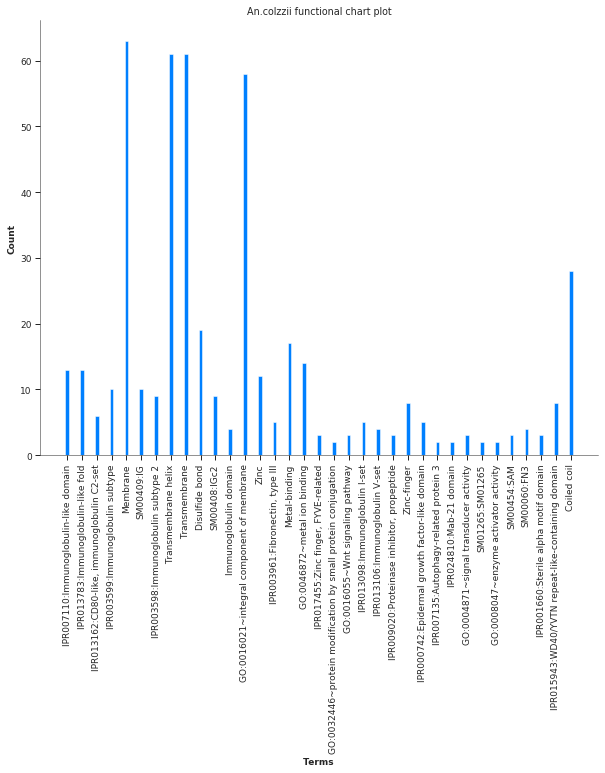

In [3]:
arr1 = np.asarray(david_chart["Count"])
arr2 = np.asarray(david_chart["Term"])
fig, ax = plt.subplots(figsize=(10, 8))
    

barWidth = 0.25

r1 = np.arange(len(arr1))


plt.bar(r1, arr1, color='#0080ff', width=barWidth, edgecolor='white')

plt.xlabel('Terms', fontweight='bold')
plt.xticks([r for r in range(len(r1))], arr2, rotation=90)
plt.ylabel('Count', fontweight='bold')

sns.despine()
ax.set_title('An.colzzii functional chart plot')
plt.show()

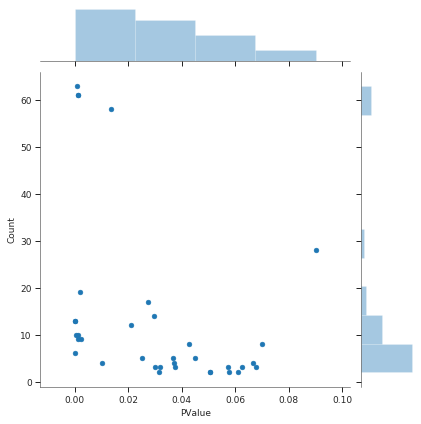

In [12]:
sns.jointplot(x="PValue", y="Count", data=david_chart);

--------------------------------------------

## Kegg database
To investigate on methabolic pathways involved I used all genes from HKA test of coluzzii and gambiae and with the software geneSCF i did GO on Kegg db:

In [14]:
kegg_coluzzii = pd.read_csv('tables/coluzzii.list_KEGG_aga_functional_classification.tsv', delimiter='\t')
kegg_coluzzii

,Genes,Process~name,num_of_Genes,gene_group,percentage%,P-value,Benjamini and Hochberg (FDR),Hommel singlewise process,Bonferroni single-step process,Hommel singlewise process,Hochberg step-up process,Benjamini and Yekutieli
0,AgaP_AGAP002914;,aga00052~Galactose_metabolism,1,23,4.347826,1.000000,1,1,1,1.0,1,1
1,AgaP_AGAP010298;,aga00190~Oxidative_phosphorylation,1,113,0.884956,1.000000,1,1,1,1.0,1,1
2,AgaP_AGAP001065;,"aga00260~Glycine,_serine_and_threonine_metabolism",1,30,3.333333,1.000000,1,1,1,1.0,1,1
3,AgaP_AGAP000971;,aga00330~Arginine_and_proline_metabolism,1,33,3.030303,1.000000,1,1,1,1.0,1,1
4,AgaP_AGAP004904;,aga00380~Tryptophan_metabolism,1,20,5.000000,1.000000,1,1,1,1.0,1,1
5,AgaP_AGAP002914;,aga00520~Amino_sugar_and_nucleotide_sugar_meta...,1,43,2.325581,1.000000,1,1,1,1.0,1,1
6,AgaP_AGAP001050;,aga00532~Glycosaminoglycan_biosynthesis,1,7,14.285714,0.996360,1,1,1,1.0,1,1
7,AgaP_AGAP002226;,aga00561~Glycerolipid_metabolism,1,34,2.941176,1.000000,1,1,1,1.0,1,1
8,AgaP_AGAP001047;,aga00562~Inositol_phosphate_metabolism,1,39,2.564103,1.000000,1,1,1,1.0,1,1
9,AgaP_AGAP002226;,aga00564~Glycerophospholipid_metabolism,1,50,2.000000,1.000000,1,1,1,1.0,1,1


In [ ]:
sns.distplot(kegg_coluzzii, )

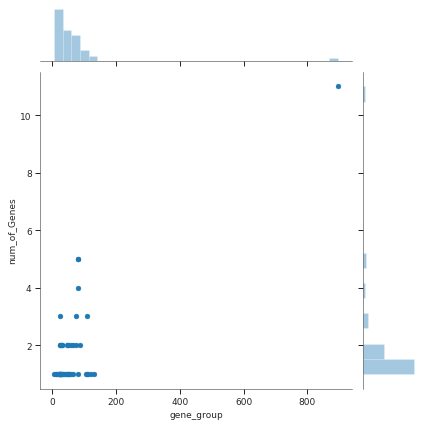

In [15]:
sns.jointplot(x="gene_group", y="num_of_Genes", data=kegg_coluzzii);

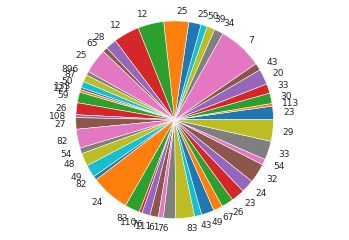

In [50]:
labels = np.asarray(kegg_coluzzii["gene_group"])
sizes = np.asarray(kegg_coluzzii["percentage%"])
 # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [3]:
kegg_gambiae = pd.read_csv('tables/gambiae.list_KEGG_aga_functional_classification.tsv', delimiter='\t')
kegg_gambiae

,Genes,Process~name,num_of_Genes,gene_group,percentage%,P-value,Benjamini and Hochberg (FDR),Hommel singlewise process,Bonferroni single-step process,Hommel singlewise process,Hochberg step-up process,Benjamini and Yekutieli
0,AgaP_AGAP010137;,aga00230~Purine_metabolism,1,79,1.265823,1.000000,1,1,1,1.0,1,1
1,AgaP_AGAP001050;,aga00532~Glycosaminoglycan_biosynthesis,1,7,14.285714,0.996287,1,1,1,1.0,1,1
2,AgaP_AGAP002226;,aga00561~Glycerolipid_metabolism,1,34,2.941176,1.000000,1,1,1,1.0,1,1
3,AgaP_AGAP001047;,aga00562~Inositol_phosphate_metabolism,1,39,2.564103,1.000000,1,1,1,1.0,1,1
4,AgaP_AGAP002226;,aga00564~Glycerophospholipid_metabolism,1,50,2.000000,1.000000,1,1,1,1.0,1,1
5,AgaP_AGAP000939;,aga00565~Ether_lipid_metabolism,1,17,5.882353,0.999997,1,1,1,1.0,1,1
6,AgaP_AGAP000973;,aga00600~Sphingolipid_metabolism,1,25,4.000000,1.000000,1,1,1,1.0,1,1
7,AgaP_AGAP013093;,aga00970~Aminoacyl-tRNA_biosynthesis,1,65,1.538462,1.000000,1,1,1,1.0,1,1
8,AgaP_AGAP001038 - AgaP_AGAP001039;,aga00981~Insect_hormone_biosynthesis,2,25,8.000000,1.000000,1,1,1,1.0,1,1
9,AgaP_AGAP000939 - AgaP_AGAP000973 - AgaP_AGAP0...,aga01100~Metabolic_pathways,7,896,0.781250,NaN,0,0,0,NaN,0,0


- <b>aga04013 MAPK signaling pathway</b>,

<b>Class: Environmental Information Processing; Signal transduction</b>
 	
The mitogen-activated protein kinase (MAPK) signaling cascades that are highly conserved from yeast to mammals use protein phosphorylation to convey signals intracellularly, and play a crucial role in mitosis, apoptosis, motility and metabolism. In fruit fly, three major classes of MAPK pathways have been distinguished with little or no redundancy, including extracellular signal-regulated kinase (ERK) / Rolled, c-Jun N-terminal kinase (JNK) / Bsk, and p38 kinase. Signals from growth factors or mitogens are dominantly transduced by the ERK pathway, whereas the JNK and p38 pathways are activated mostly by environmental stresses. The MAPK signaling cascades are typically linked to regulation of gene expression, because transcription factors are often the targets of regulatory phosphorylation events. 

https://www.genome.jp/dbget-bin/www_bget?aga04013

- <b>aga04150 mTOR signaling pathway</b>,

<b>Class:Environmental Information Processing; Signal transduction</b>
 	
The mammalian (mechanistic) target of rapamycin (mTOR) is a highly conserved serine/threonine protein kinase, which exists in two complexes termed mTOR complex 1 (mTORC1) and 2 (mTORC2). mTORC1 contains mTOR, Raptor, PRAS40, Deptor, mLST8, Tel2 and Tti1. mTORC1 is activated by the presence of growth factors, amino acids, energy status, stress and oxygen levels to regulate several biological processes, including lipid metabolism, autophagy, protein synthesis and ribosome biogenesis. On the other hand, mTORC2, which consists of mTOR, mSin1, Rictor, Protor, Deptor, mLST8, Tel2 and Tti1, responds to growth factors and controls cytoskeletal organization, metabolism and survival.

https://www.genome.jp/dbget-bin/www_bget?aga04150

- <b>aga04310 Wnt signaling pathway</b>,

<b>Class: Environmental Information Processing; Signal transduction</b>
 	
Wnt proteins are secreted morphogens that are required for basic developmental processes, such as cell-fate specification, progenitor-cell proliferation and the control of asymmetric cell division, in many different species and organs. There are at least three different Wnt pathways: the canonical pathway, the planar cell polarity (PCP) pathway and the Wnt/Ca2+ pathway. In the canonical Wnt pathway, the major effect of Wnt ligand binding to its receptor is the stabilization of cytoplasmic beta-catenin through inhibition of the bea-catenin degradation complex. Beta-catenin is then free to enter the nucleus and activate Wnt-regulated genes through its interaction with TCF (T-cell factor) family transcription factors and concomitant recruitment of coactivators. Planar cell polarity (PCP) signaling leads to the activation of the small GTPases RHOA (RAS homologue gene-family member A) and RAC1, which activate the stress kinase JNK (Jun N-terminal kinase) and ROCK (RHO-associated coiled-coil-containing protein kinase 1) and leads to remodelling of the cytoskeleton and changes in cell adhesion and motility. WNT-Ca2+ signalling is mediated through G proteins and phospholipases and leads to transient increases in cytoplasmic free calcium that subsequently activate the kinase PKC (protein kinase C) and CAMKII (calcium calmodulin mediated kinase II) and the phosphatase calcineurin.

https://www.genome.jp/dbget-bin/www_bget?pathway+aga04310